In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from joblib import dump
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             f1_score, make_scorer, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from ml_model import PipelineManager
from utils.GPU_models import KerasClassifierModel, gpu_model_hub
from utils.preprocessing_utils import (clean_labs, clean_notas,
                                       clean_sociodemograficos, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
retrain_with_class_weight=False
add_gpu_prediction = False
consolidate_classes = False

## Data load

In [3]:
df_notas = pd.read_csv('data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('data/sociodemografico.csv', sep=';')

In [4]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [5]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [7]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


## Data Cleaning

In [8]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios)
df_notas = clean_notas(df_notas)

### Merge the sociodemographic data with the medical notes dataset

In [9]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"explica acerca programa, recomienda adherencia..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente diagnostico. Reforz...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL CADA FOSA NASA...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO MES-INFECTOLOGIA VALORACIOJN IN...


## Feature Engineering

In [10]:
# Consolidate the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

KeyError: "Column(s) ['Nombre_lab'] do not exist"

## Label encoding

In [ ]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([  977,    94,  2614,  1970, 60586, 47408,  6278, 17437,  2808]))

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Further feature engineering

In [ ]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "universal"

if add_gpu_prediction:
    model_function = gpu_model_hub
    clf = KerasClassifierModel(
        build_fn=model_function,
        class_number=len(df_notas[target_feature].unique()),
        embedding = embedding,
        epochs=400,
        batch_size=400,
        verbose=10,
    )

    clf.fit(X_train[text_feature], y_train)
    clf.plot_learning_curves('data/output/gpu_model')

In [ ]:
if add_gpu_prediction:
    y_pred = clf.predict(X_test[text_feature])
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())

In [ ]:
if add_gpu_prediction:
    X_pred = clf.predict(df_merge[text_feature])
    df_merge['GPU_prediction'] = X_pred
    df_merge

## Hyperparameter Setup

In [ ]:
numerical_features = list(set(['Edad', 'top_lab_avg_value', 'top_lab_max_value', 'top_lab_count', 'total_lab_count'] + list(df_merge.drop(columns='IDRecord').select_dtypes(include='int64').columns)))
categorical_features = ['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo', 'top_lab_name']

In [ ]:
if 'GPU_prediction' in df_merge:
    categorical_features.append('GPU_prediction')

pipeline = PipelineManager(estimator="classifier")
pipeline.set_numerical_features(numerical_features)
pipeline.set_categorical_features(categorical_features)
pipeline.set_text_feature(text_feature)
pipeline.set_basic_pipeline()

param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(1, 10, 5, dtype=int)) + [None],
    "bootstrap": [True, False],
}
estimator = RandomForestClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
    "n_estimators": np.linspace(1, 100, 10, dtype=int),
    "max_depth": list(np.linspace(2, 10, 5, dtype=int)) + [None],
    "eta":  np.linspace(0.01, 0.5, 10, dtype=float),
    "min_child_weight": np.linspace(0.5, 20, 5, dtype=float),
    "gamma": np.linspace(0, 1, 5, dtype=float),
    "subsample": np.linspace(0.1, 1, 5, dtype=float),
    "colsample_bytree": np.linspace(0.2, 1, 5, dtype=float),
    "reg_lambda": np.linspace(0, 10, 100, dtype=float),
    "reg_alpha": np.linspace(0, 10, 100, dtype=float),
    # "scale_pos_weight": np.linspace(0.1, 500, 100, dtype=float),
}
estimator = XGBClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
}
estimator = PassiveAggressiveClassifier()
pipeline.add_estimator(estimator, param_grid)


param_grid = {
}
estimator = SGDClassifier()
pipeline.add_estimator(estimator, param_grid)

param_grid = {
    'C': np.linspace(0, 2, 10, dtype=float),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['auto', 'scale'],
    'class_weight': ['balanced'],
}
estimator = SVC()
pipeline.add_estimator(estimator, param_grid)


pipeline.pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo', 'top_lab_name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   Simp...
                                                                   CountVectorizer(stop_words=['de',
                                                                                               'la',
                                                                                               'que',
                                                                                               'el',
                                                                                               'en',
                                                                                               'y',
                                                                                               'a',
                                                                                               'los',
                                                                                               'del',
                                                                                               'se',
                                                                                               'las',
                                                                                               'por',
                                                                                               'un',
                                                                                               'para',
                                                                                               'con',
                                                                                               'no',
                                                                                               'una',
                                                                                               'su',
                                                                                               'al',
                                                                                               'lo',
                                                                                               'como',
                                                                                               'más',
                                                                                               'pero',
                                                                                               'sus',
                                                                                               'le',
                                                                                               'ya',
                                                                                               'o',
                                                                                               'este',
                                                                       

## Hyperparameter tuning

In [ ]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=df_merge[target_feature])

scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }
best_model = pipeline.find_best_model(
    X_train,
    y_train,
    cv=2,
    n_iter=8,
    n_jobs=1,
    scoring=scoring,
    refit='Weighted_F1',
    verbose = 1,
    )

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

In [ ]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genero', 'GrupoEtnico',
                                                   'AreaResidencial',
                                                   'EstadoCivil', 'TSangre',
                                                   'Tipo', 'top_lab_name']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNI...
                               gamma=0.25, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.0644444451, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0,
                               min_child_weight=5.375, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, ...))])

In [ ]:
with pd.option_context('display.max_columns', None):
    display(pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,param_estimator__subsample,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__gamma,param_estimator__eta,param_estimator__colsample_bytree,param_estimator,params,split0_test_Accuracy,split1_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
0,524.317806,147.053060,15.021284,0.364849,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),1.0,2.020202,4.242424,100,5.375,10,0.25,0.064444,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.292795,0.283246,0.288020,0.004774,1,0.651105,0.640122,0.645613,0.005492,1
1,63.184745,33.770791,1.220595,0.012499,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),VarianceThreshold(),0.775,8.282828,9.494949,78,5.375,6,0.75,0.336667,0.6,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.290679,0.278906,0.284793,0.005886,2,0.641928,0.630296,0.636112,0.005816,2
5,73.904574,2.233244,5.120540,0.245442,"CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),Normalizer(),SimpleImputer(strategy='median'),VarianceThreshold(),1.0,2.929293,4.646465,23,20.0,8,1.0,0.5,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.278010,0.274488,0.276249,0.001761,3,0.630594,0.629145,0.629870,0.000724,3
4,201.314734,73.084511,2.513194,0.144431,"CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),RobustScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.775,6.060606,3.333333,45,5.375,10,0.75,0.118889,0.8,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.279371,0.269772,0.274571,0.004799,4,0.636942,0.617956,0.627449,0.009493,4
3,101.200264,2.408804,2.421969,0.286483,"CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.775,5.858586,5.353535,67,0.5,6,1.0,0.227778,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.254949,0.249748,0.252348,0.002601,5,0.601627,0.593495,0.597561,0.004066,5
6,98.131712,4.186244,12.135759,0.238570,"CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(sublinear_tf=True),StandardScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.775,7.272727,8.181818,89,10.25,6,0.75,0.5,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.241260,0.238774,0.240017,0.001243,6,0.594367,0.590970,0.592669,0.001699,6
2,22.903248,3.110448,1.334182,0.066287,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.775,6.767677,9.69697,45,0.5,None,0.25,0.118889,0.2,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.228213,0.230584,0.229399,0.001185,7,0.578439,0.575437,0.576938,0.001501,7
7,3.513164,0.252085,1.702210,0.014790,"CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.775,2.020202,1.111111,1,10.25,None,0.75,0.336667,1.0,"XGBClassifier(base_score=None, booster=None, c...",{'preprocessor__text__vectorizer': CountVector...,0.213239,0.215339,0.214289,0.001050,8,0.517847,0.5

In [ ]:
pipeline.cv_results.sort_values(by=["rank_test_Weighted_F1"])[[
    'rank_test_Weighted_F1',
    'rank_test_Accuracy',
    'mean_fit_time',
    'param_estimator',
    'param_preprocessor__text__vectorizer',
    'param_preprocessor__text__tfidf',
    'param_preprocessor__numerical__scaler',
    'param_preprocessor__numerical__imputer', 'param_feature_selector',
    'mean_test_Accuracy',
    'mean_test_Weighted_F1'
    ]]

,rank_test_Weighted_F1,rank_test_Accuracy,mean_fit_time,param_estimator,param_preprocessor__text__vectorizer,param_preprocessor__text__tfidf,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,param_feature_selector,mean_test_Accuracy,mean_test_Weighted_F1
0,1,1,524.317806,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(),MinMaxScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.288020,0.645613
1,2,2,63.184745,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(),MinMaxScaler(),SimpleImputer(),VarianceThreshold(),0.284793,0.636112
5,3,3,73.904574,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(1, 3),\n ...",TfidfTransformer(norm='l1'),Normalizer(),SimpleImputer(strategy='median'),VarianceThreshold(),0.276249,0.629870
4,4,4,201.314734,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(3, 3),\n ...",TfidfTransformer(sublinear_tf=True),RobustScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.274571,0.627449
3,5,5,101.200264,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(4, 4),\n ...","TfidfTransformer(norm='l1', sublinear_tf=True)",MinMaxScaler(),SimpleImputer(strategy='median'),VarianceThreshold(),0.252348,0.597561
6,6,6,98.131712,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(ngram_range=(2, 2),\n ...",TfidfTransformer(sublinear_tf=True),StandardScaler(),KNNImputer(),SelectFromModel(estimator=Ridge()),0.240017,0.592669
2,7,7,22.903248,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),MinMaxScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.229399,0.576938
7,8,8,3.513164,"XGBClassifier(base_score=None, booster=None, c...","CountVectorizer(stop_words=['de', 'la', 'que',...",TfidfTransformer(norm='l1'),StandardScaler(),SimpleImputer(strategy='most_frequent'),VarianceThreshold(),0.214289,0.520244


In [ ]:
# Retrain the model using a sample-weighting mechanism to try to compensate for the dataset imbalance
if retrain_with_class_weight:
    from sklearn.utils.class_weight import compute_sample_weight
    sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=y_train,
    )

    best_model.fit(X_train, y_train, estimator__sample_weight=sample_weights)

## Scoring

In [ ]:
score = pipeline.score(X_test, y_test)
score

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ROC_AUC,accuracy,balanced_accuracy,micro_f1_score,macro_f1_score,weighted_f1_score,confusion_matrix,confusion_matrix_normalized,classification_report
0,0.874063,0.704587,0.333376,0.704587,0.371498,0.682953,"[[10, 0, 0, 0, 704, 66, 0, 2, 0], [0, 0, 0, 0,...","[[8.917583691522945e-05, 0.0, 0.0, 0.0, 0.0062...",precision recall f1-score ...


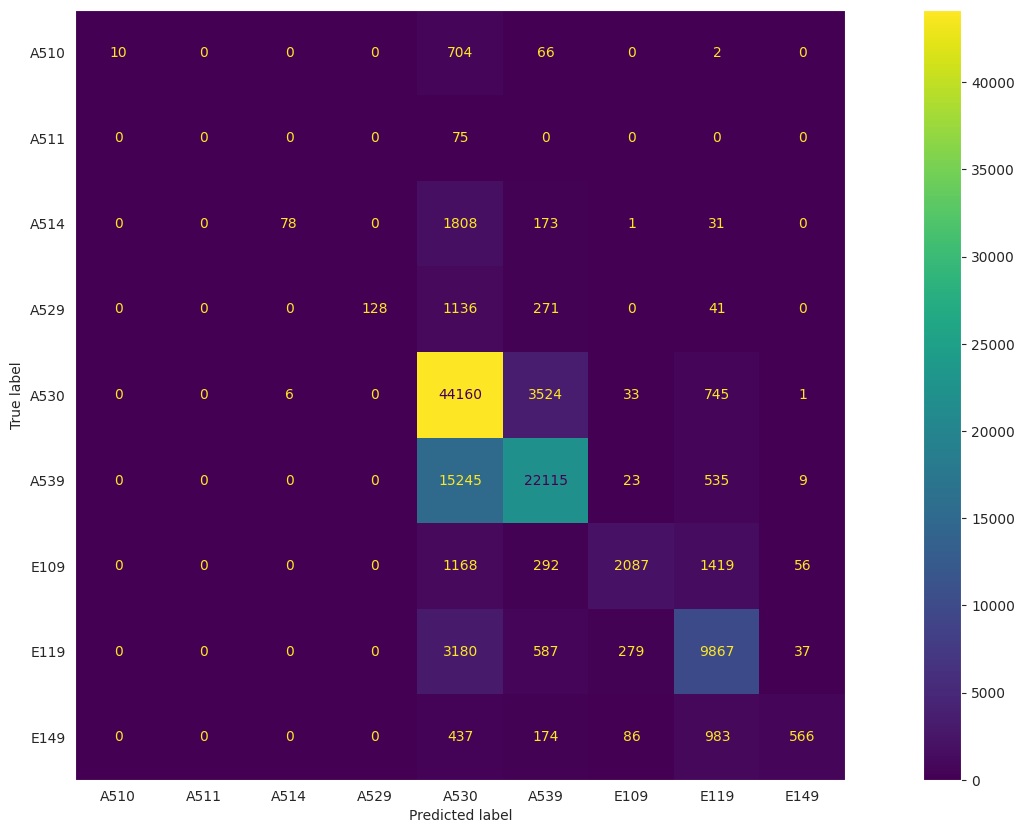

In [ ]:
labels_decoded = label_encoder.inverse_transform(best_model['estimator'].classes_)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=score.loc[0,'confusion_matrix'],
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

In [ ]:
score.loc[0,'classification_report'].round(2).rename(index={str(class_label):label for class_label, label in zip(best_model['estimator'].classes_, labels_decoded)})

,precision,recall,f1-score,support
A510,1.00,0.01,0.03,782.0
A511,0.00,0.00,0.00,75.0
A514,0.93,0.04,0.07,2091.0
A529,1.00,0.08,0.15,1576.0
A530,0.65,0.91,0.76,48469.0
A539,0.81,0.58,0.68,37927.0
E109,0.83,0.42,0.55,5022.0
E119,0.72,0.71,0.72,13950.0
E149,0.85,0.25,0.39,2246.0
accuracy,0.70,0.70,0.70,0.7


## Saving the best performing model

In [ ]:
save_path = Path('data') / 'output' / 'best_model.pickle'
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))

['data/output/best_model_score.pickle']